#                                       ** PREDICTION NEWYORK TAXI TRIP DURATIONS**


### **Headings**
* I.   Importing modules 
* II.  Loading files 
* II.  Data processing
* IV. Exporatory data analysis 
* V.  Algorithme 
* VI. submission

#  **I. Importing modules**

In [1]:
import os 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import matplotlib.mlab as mlab
import warnings
warnings.filterwarnings("ignore")


from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_squared_error as MSE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict



# Settings
import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8.5, 5)
plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.mpl.rc("figure", figsize=(8.5,5))


%matplotlib inline

# **II. Loading files**

In [2]:
import os

train = pd.read_csv ('../input/train.csv')
test = pd.read_csv ('../input/test.csv')

train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663


# **III. Data processing**

##  Pre-Processing Data
After loading our data, we need to examine the structure of data to out find out what are possible missing values and outiliers.

### 1. Pre-processing Data : Missing values 

In [3]:
print(train.shape);


(1458644, 11)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


The pickup and dropoff timestamp variables are being treated as non-null objects. These features should be converted to date objects to allow for easier feature engineering later on in Data type pre-processing section (section **III.a.3**)

In [5]:
#### we have no missing value in our data set. 
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### 2. Pre-processing Data : Outliers

In [6]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.000,1.535,0.499,1.000,1.000,2.000,2.000,2.000
passenger_count,1458644.000,1.665,1.314,0.000,1.000,1.000,2.000,9.000
pickup_longitude,1458644.000,-73.973,0.071,-121.933,-73.992,-73.982,-73.967,-61.336
pickup_latitude,1458644.000,40.751,0.033,34.360,40.737,40.754,40.768,51.881
dropoff_longitude,1458644.000,-73.973,0.071,-121.933,-73.991,-73.980,-73.963,-61.336
dropoff_latitude,1458644.000,40.752,0.036,32.181,40.736,40.755,40.770,43.921
trip_duration,1458644.000,959.492,5237.432,1.000,397.000,662.000,1075.000,3526282.000


**Passenger_count** : Rationaly we would consider a trip with at least a passenger, so values with zero shall be deleted. LIkely trips with number of passengers above 5 shall be deleted because law provide that a a maximum number of passenger should not exced 5 persons, though in some few exception, passengers under the age of 7 who may sit on an adult's lap. However it unlikely that a full 5 person taxi cab would have that many children under the age of 7.   

**Longitude and Latitude Coordinates** 
Further More, New York City cordinates are normaly found between :
*          Latitude is between 40.7128 and 40.748817
*          Longitude is between - 74.0059 and - 73.968285

**Trip_duration**
Lastly, there are unusual observations present in our target variable, trip_duration. The maximum trip_duration is unrealistic : 3526282.00 sec ( approximatively 980 hours). To get ride of this outlayers we will exclude all data points that are a specified number of standard deviations away from the mean.
We will remove trip_duration observations that are more than two standard deviations away from the mean duration time, 



In [7]:
train = train[train['passenger_count']>0]
train = train[train['passenger_count']<9]

In [8]:
#Pro-processing Pickup cordinates
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]


#Pro-processing dropoff cordinates 
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [9]:
#Pre-processing trip duration 
trip_duration_mean = np.mean(train['trip_duration'])
trip_duration_std = np.std(train['trip_duration'])
train = train[train['trip_duration']<=trip_duration_mean + 2*trip_duration_std]
train = train[train['trip_duration']>= trip_duration_mean - 2*trip_duration_std]

In [10]:
# Confirm removal
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,1437076.000,1.534,0.499,1.000,1.000,2.000,2.000,2.000
passenger_count,1437076.000,1.664,1.314,1.000,1.000,1.000,2.000,6.000
pickup_longitude,1437076.000,-73.974,0.037,-74.030,-73.992,-73.982,-73.968,-73.751
pickup_latitude,1437076.000,40.751,0.027,40.630,40.737,40.754,40.768,40.850
dropoff_longitude,1437076.000,-73.974,0.033,-74.030,-73.991,-73.980,-73.963,-73.750
dropoff_latitude,1437076.000,40.752,0.030,40.630,40.736,40.755,40.770,40.850
trip_duration,1437076.000,824.448,644.681,1.000,394.000,655.000,1056.000,11411.000


### 3. Pre-processing Data : Data type
   Here we extract dates, by converting them  "object" type to "datetime" type.               

In [11]:
# Pickups
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime']) 

# Drop-offs
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime']) 

In [12]:
# Confirm changes
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437076 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1437076 non-null object
vendor_id             1437076 non-null int64
pickup_datetime       1437076 non-null datetime64[ns]
dropoff_datetime      1437076 non-null datetime64[ns]
passenger_count       1437076 non-null int64
pickup_longitude      1437076 non-null float64
pickup_latitude       1437076 non-null float64
dropoff_longitude     1437076 non-null float64
dropoff_latitude      1437076 non-null float64
store_and_fwd_flag    1437076 non-null object
trip_duration         1437076 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 131.6+ MB


### 4. Pre-processing data : new features
Pickup_date and dropoff_date contain unit information that we can extract individually to get new features that would help us to vizualize the data set. 

In [13]:
# Decomposing pickup_datetime variable into date and time
train['pickup_date'] = train['pickup_datetime'].dt.date # Extract date
train['pickup_time'] = train['pickup_datetime'].dt.time # Extract time

# Decomposing dropoff_datetime variable into date and time 
train['dropoff_date'] = train['dropoff_datetime'].dt.date # Extract date
train['dropoff_time'] = train['dropoff_datetime'].dt.time # Extract time



# Additional pickup features
train['pickup_month'] = train['pickup_datetime'].dt.month # Extract month

train['pickup_hour'] = train['pickup_datetime'].dt.hour # Extract hour

train['pickup_weekday'] = train['pickup_datetime'].dt.dayofweek # Extract day of week

In [14]:
# Drop concatentated timestamp columns
train.drop(['pickup_datetime'], axis = 1, inplace = True)
train.drop(['dropoff_datetime'], axis = 1, inplace = True)

# Confirm removal
train.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday'],
      dtype='object')

In [15]:
# Differences between dropoff and pickup geocardiante helps to calculate distance covered during a trips

train['dist_long'] = train['pickup_longitude'] - train['dropoff_longitude']
#test['dist_long'] = test['pickup_longitude'] - test['dropoff_longitude']

train['dist_lat'] = train['pickup_latitude'] - train['dropoff_latitude']
#test['dist_lat'] = test['pickup_latitude'] - test['dropoff_latitude']


# Distance covered
train['dist'] = np.sqrt(np.square(train['dist_long']) + np.square(train['dist_lat']))
#test['dist'] = np.sqrt(np.square(test['dist_long']) + np.square(test['dist_lat']))

# **IV. Exploratory Data Analysis (Visualization)**

## 1.Target Variable: trip_duration

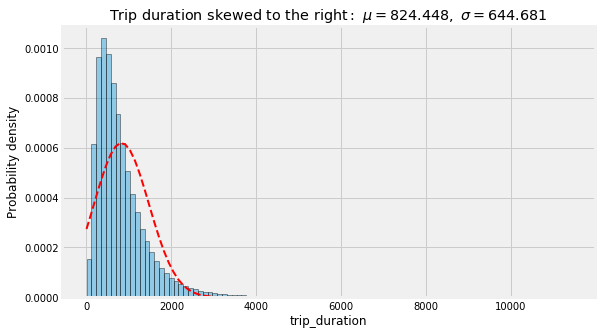

In [16]:
# Mean distribution
mu = train['trip_duration'].mean()

# Std distribution
sigma = train['trip_duration'].std()
num_bins = 100

# Histogram 
fig = plt.figure(figsize=(8.5, 5))
n, bins, patches = plt.hist(train['trip_duration'], num_bins, normed=1,
                           edgecolor = 'black', lw = 1, alpha = .40)
# Normal Distribution
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('trip_duration')
plt.ylabel('Probability density')

# Adding a title
plt.title(r'$\mathrm{Trip\ duration\ skewed \ to \ the \ right:}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)
#fig.tight_layout()
plt.show();



## 2.Passenger count per trip duration

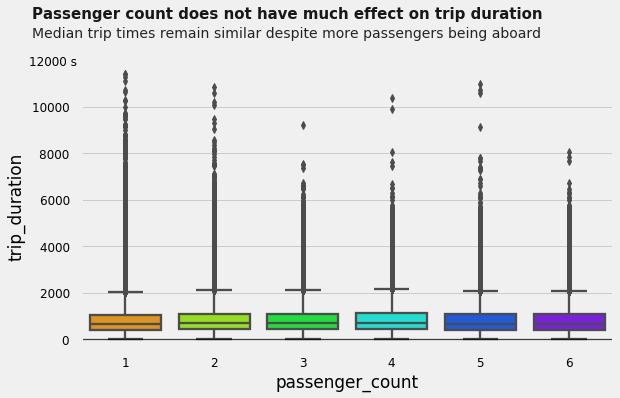

In [17]:

import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
passenger_graph = sns.boxplot(x = 'passenger_count', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick size
passenger_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)


# Customize tick labels of the y-axis
passenger_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])


# Bolding horizontal line at y = 0
passenger_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)


# # Adding a title and a subtitle
passenger_graph.text(x =-1.05, y = 13800, s = "Passenger count does not have much effect on trip duration",
               fontsize =15 , weight = 'bold', alpha = .90)
passenger_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times remain similar despite more passengers being aboard',
              fontsize = 14, alpha = .85)
plt.show()



## 3.Trip duration in a week

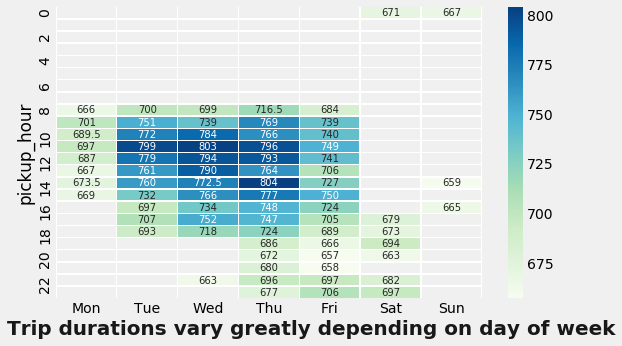

In [18]:
# Trips by Hour and Day of Week
trip_duration_median = train['trip_duration'].median()
plt.figure(figsize=(8.5,5))

pickup_hourday = train.groupby(['pickup_hour','pickup_weekday'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median], lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )


# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])


# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# # Adding a title and a subtitle
hourday_graph.text(x =-.8, y = 27, s = "Trip durations vary greatly depending on day of week",
               fontsize =20 , weight = 'bold', alpha = .90)

plt.show()

Trips tend much longer than the median trip_duration of 655 seconds during the following parts of the week:

* **Monday** - Thursday Office Hours: 8:00 am - 6:00 pm
* **Thursday**, **Friday, Saturday Nights**: 6:00 pm - midnight
* **Early Saturday** & **Sunday Mornings**: 12:00 am - 1:00 am
* **Sunday Afternoons**: 2:00 pm and 4:00 pm

## 4.Trip Duration by Month

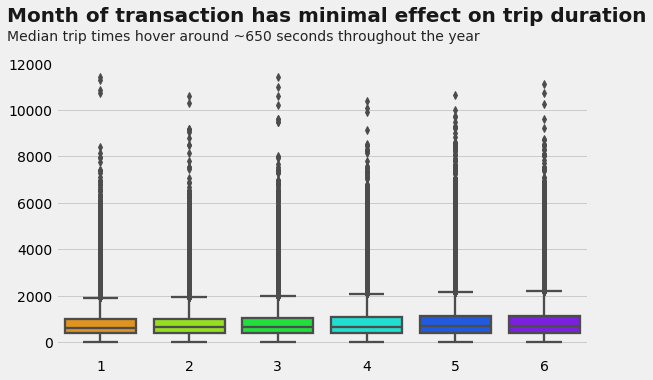

pickup_month,1,2,3,4,5,6
count,226431.000,235043.000,252434.000,247849.000,244581.000,230738.000
mean,779.180,778.272,805.638,834.930,869.895,877.056
std,599.652,582.846,617.997,642.635,702.520,703.833
min,1.000,1.000,1.000,1.000,1.000,1.000
25%,381.000,381.000,390.000,400.000,405.000,411.000
50%,623.000,629.000,646.000,667.000,681.000,687.000
75%,996.000,1005.000,1035.000,1076.000,1112.000,1120.000
max,11411.000,10574.000,11406.000,10380.000,10632.000,11099.000


In [19]:
# Box plot of pickups by month
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
month_graph = sns.boxplot(x = 'pickup_month', y = 'trip_duration', data = train, palette = 'gist_rainbow', linewidth = 2.3)

# Remove the label of the x-axis
month_graph.xaxis.label.set_visible(False)
month_graph.yaxis.label.set_visible(False)

month_graph.text(x =-1.05, y = 13800, s = "Month of transaction has minimal effect on trip duration",
               fontsize =20 , weight = 'bold', alpha = .90)
month_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times hover around ~650 seconds throughout the year',
              fontsize = 14, alpha = .85)
plt.show()


# Statistical summary
train.groupby('pickup_month')['trip_duration'].describe().transpose()



June has the highest median trip_duration overall, but only slightly. Median trip times seem to hover around the 10-12 minute mark and do not vary much from month-to-month. This may be an indication that this month feature will not be helpful in predicting our target variable, trip_duration. 


List the numerical features in decending order by their correlation with trip_duration:

dist: 0.7649971717532931
pickup_longitude: 0.3632691702226197
dropoff_longitude: 0.25548835909396256
pickup_latitude: -0.23548982525753842
dropoff_latitude: -0.19720945010930235
dist_long: 0.1211765958512815
pickup_month: 0.059455091448905886
pickup_weekday: -0.03544469782338135
pickup_hour: 0.03025386122067256
dist_lat: -0.02040568865564871
passenger_count: 0.015344197884831583


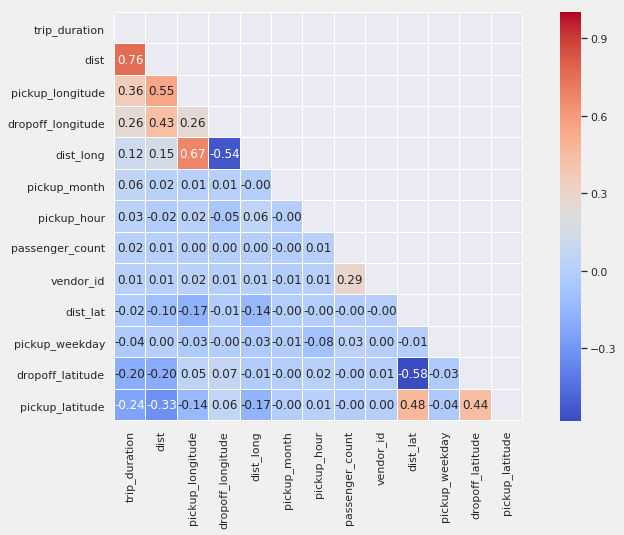

In [20]:
# Correlations to trip_duration
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict = corr['trip_duration'].to_dict()
del cor_dict['trip_duration']
print("List the numerical features in decending order by their correlation with trip_duration:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: {1}".format(*ele))
    
# Correlation matrix heatmap
corrmat = train.corr()
plt.figure(figsize=(12, 7))

# Number of variables for heatmap
k = 76
cols = corrmat.nlargest(k, 'trip_duration')['trip_duration'].index
cm = np.corrcoef(train[cols].values.T)

# Generate mask for upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                 fmt='.2f',annot_kws={'size': 12}, yticklabels=cols.values,\
                 xticklabels=cols.values, cmap = 'coolwarm',lw = .1)
plt.show() 

There is quite a good correlation between distance and trip duration(our target). 

# **V. Algorithme**

## 1.Droping unnecessary features and incoding store_and_fwd_flag
We need to convert store_and_fwd_flag to numeric so as to get it into a ready to use in our model.

In [21]:
# Encoding Categoric data (converting 'store_and_fwd_flag' to numeric)
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N':0,'Y':1})

In [22]:
train.drop(columns=['pickup_date','pickup_time','dropoff_date', 'dropoff_time', 'dist_long', 'dist_lat'], axis = 1, inplace = True)

In [23]:
train.head(3)

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_hour,pickup_weekday,dist
0,id2875421,2,1,-73.982,40.768,-73.965,40.766,0,455,3,17,0,0.018
1,id2377394,1,1,-73.980,40.739,-73.999,40.731,0,663,6,0,6,0.020
2,id3858529,2,1,-73.979,40.764,-74.005,40.710,0,2124,1,11,1,0.060


## 2. Feature Enginering

In [24]:
X = train[['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour',
       'pickup_weekday', 'dist']]

# Target
y = train['trip_duration']

##     3. Train/valid spliting

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.2, random_state = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1149660, 11), (1149660,), (287416, 11), (287416,))

## 3.Model  selection 1 :  (Linear Regression)

In [26]:
#instantiate model
lr = LinearRegression()

# Fit to training data
lr = lr.fit(X_train,y_train);

#Predict
y_pred_lr = lr.predict(X_val)

In [27]:
#cross_validation_score
cvs_lr = np.sqrt(
    -cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(cvs_lr)

mean_cvs_lr = np.mean(cvs_lr)
print(mean_cvs_lr)

[405.13840956 404.84240589 405.79096581 404.83149789 403.97562858]
404.91578154440793


In [28]:
# Score It
from sklearn import metrics
print('\nRandom Forest Regression Performance Metrics')
print('R^2 =',metrics.explained_variance_score(y_val,y_pred_lr))
print('MAE',metrics.mean_absolute_error(y_val, y_pred_lr))
print('MSE',metrics.mean_squared_error(y_val, y_pred_lr))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_val, y_pred_lr)))


Random Forest Regression Performance Metrics
R^2 = 0.6064865757438818
MAE 276.1325256327022
MSE 164159.12281107184
RMSE 405.16554988186226


R2 (R squared) is the proportion of the variance in the dependent variable that is predictable from the independent variable.The better the linear regression fits the data in comparison to the simple average, the closer the value of R^2 is to 1.
In this case, R only 60% of the variation in the dependent variable is explained by this model. Such a score is an indication that the relationship between the features and independent variable is average. May be this score can be improuve with a non-linear model. 

## 4.Model selection 2 : RandomForest 

In [29]:
#model selection 
from sklearn.ensemble import RandomForestRegressor

# Intantiate model 
rf = RandomForestRegressor(n_estimators = 20, n_jobs = -1)

#fit
rf = rf.fit(X_train, y_train)

#Predict
y_pred_rf = rf.predict(X_val)

# crosse validation
cvs_rf = cross_val_score(rf, X_train, y_train, cv=5)
print(cvs_rf)

mean_cvs_rf = np.mean(cvs_rf)
print(mean_cvs_rf)

[0.78159867 0.77993161 0.77727196 0.77991885 0.78404357]
0.7805529312919253


In [30]:
from sklearn import metrics
print('\nRandom Foresst Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_val,y_pred_rf))
print('MAE:',metrics.mean_absolute_error(y_val,y_pred_rf))
print('MSE:',metrics.mean_squared_error(y_val,y_pred_rf))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_val,y_pred_rf)))
print('RMSLE:',np.sqrt(metrics.mean_squared_log_error(y_val, y_pred_rf)))


Random Foresst Performance Metrics
R^2= 0.7834499973773233
MAE: 187.59641052599054
MSE: 90424.23126180843
RMSE: 300.70622085651706
RMSLE: 0.39523985146874757




Base on comparaison of performance metrics of the both model, we decide to use the Random Forest type to make our submission as following. 

#  **VI. Submission**

    In order to submit we need to reshape test data like we did on train data set, so that our model(Random Forest) can be use to predict. 

## 1. Preprocessing Test data set 

In [31]:
# Test data info
test.info()

# Test data shape
print('shape',test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB
shape (625134, 9)


In [32]:
# Convert timestamps to date objects
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime) # Pickups

# Delimit pickup_datetime variable 
test['pickup_date'] = test['pickup_datetime'].dt.date # Extract date
test['pickup_time'] = test['pickup_datetime'].dt.time # Extract time

# Additional pickup features
test['pickup_month'] = test['pickup_datetime'].dt.month # Extract month

#train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
test['pickup_hour'] = test['pickup_datetime'].dt.hour # Extract hour
test['pickup_weekday'] = test['pickup_datetime'].dt.dayofweek # Extract day of week

# Encode categorical variables
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'N':0,'Y':1})


# Differences between dropoff and pickup geocardiante helps to calculate distance covered during a trips
test['dist_long'] = test['pickup_longitude'] - test['dropoff_longitude']
test['dist_lat'] = test['pickup_latitude'] - test['dropoff_latitude']

# Distance covered
test['dist'] = np.sqrt(np.square(test['dist_long']) + np.square(test['dist_lat']))

#drop useless colomns
test.drop(columns=['pickup_datetime', 'pickup_date', 'dist_long', 'dist_lat'], axis = 1, inplace = True)



In [33]:
# Create new matrix of features from test data
X_test= test[['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour',
       'pickup_weekday', 'dist']]

# Feed features into random forest
test_pred= rf.predict(X_test)

In [34]:
submission = pd.DataFrame({'id':test['id'], 'trip_duration': test_pred})
submission.to_csv('mySubmission.csv', index=False)
